In [4]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,12)

import requests
import json
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional
#from keras.losses import BinaryCrossentropy
from keras.optimizers import RMSprop
#from keras.metrics import AUC
from keras import Sequential, Input
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

**TABLE OF CONTENT**

--- 
# Data Query
## Prices Query
- Platform is coinBase
- BTC/USD price

In [5]:
url_call = 'https://min-api.cryptocompare.com/data/v2/histohour?fsym=BTC&tsym={}&limit={}&e=Coinbase'

# get data
currency = 'EUR'
n_batch_obs = 8
n_obs = n_batch_obs * 2000
reqs = []

if n_obs > 2000:
    
    # Initial Call
    req = json.loads(requests.get(url_call.format(currency, 2000)).text)
    print('- {}/BTC Prices from {} to {} '.format(currency, req['Data']['TimeFrom'], req['Data']['TimeTo']))
    reqs.append(req)
    
    for i in range(1, n_batch_obs):
        # Second query to ave double the history if n_obs > 2000
        req = json.loads(requests.get(url_call.format(currency, 2000) + '&toTs={}'.format(req['Data']['TimeFrom'])).text)
        print('- {}/BTC Prices from {} to {} '.format(currency, req['Data']['TimeFrom'], req['Data']['TimeTo']))
        reqs.append(req)

else:

    req = json.loads(requests.get(url_call.format(currency, n_obs)).text)
    print('- {}/BTC Prices from {} to {} '.format(currency, req['Data']['TimeFrom'], req['Data']['TimeTo']))
    reqs.append(req)



- EUR/BTC Prices from 1589425200 to 1596625200 
- EUR/BTC Prices from 1582225200 to 1589425200 
- EUR/BTC Prices from 1575025200 to 1582225200 
- EUR/BTC Prices from 1567825200 to 1575025200 
- EUR/BTC Prices from 1560625200 to 1567825200 
- EUR/BTC Prices from 1553425200 to 1560625200 
- EUR/BTC Prices from 1546225200 to 1553425200 
- EUR/BTC Prices from 1539025200 to 1546225200 


In [6]:
# Format as dataframe & sort DatetimeIndex
df = pd.concat([pd.DataFrame(req['Data']['Data']) for req in reqs], axis=0)
df.index = pd.to_datetime(df['time'], origin='unix', unit='s')
df.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
df.sort_index(ascending=True, inplace=True)
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15996 entries, 2018-10-08 19:00:00 to 2020-08-05 11:00:00
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close       15996 non-null  float64
 1   high        15996 non-null  float64
 2   low         15996 non-null  float64
 3   open        15996 non-null  float64
 4   volumefrom  15996 non-null  float64
 5   volumeto    15996 non-null  float64
dtypes: float64(6)
memory usage: 874.8 KB


## News query

# Features Engineering
## Features Computation

In [7]:
def rolling_tscores(series, window):
    '''
    Compute the T-Score on the previous values from a rolling window
    in order to not calculate a t-score based on a distribution containing future values

    return: time series of the t-score based on previous values window sample
    '''

    # Get the rolling window
    roll_series = series.rolling(window)

    # Get the mean & std of the sample of previous records (distribution)
    m = roll_series.mean().shift(1)
    s = roll_series.std(ddof=0).shift(1)

    tscores = (series - m) / s

    return tscores

In [8]:
# original columns to keep
orig_cols = df.columns.tolist()[-2:]

#----------------------
# Movements and pct return (time step is hour)
periods = [1, 6, 12, 24]
movs_list = [df.diff(i) for i in periods]# + [df.pct_change(i) for i in periods]
movs_labels = []

for i in periods:
    # Labels for the time derivatives
    movs_labels += [col + '_mov{}H'.format(i) for col in df.columns]
    
#for i in periods:
    # Labels for pct change
    #movs_labels += [col + '_return{}H'.format(i) for col in df.columns]

# Concatenate
feats_df = pd.concat([df.loc[:, orig_cols]] + movs_list, axis=1)
feats_df.columns = orig_cols + movs_labels

print(feats_df.info())


#----------------------
# Rolling Statistics & T-Score
for col in feats_df.columns:
    # Get the series
    series = feats_df.loc[:, col]
    
    for i in periods[1:]:

        # Moving Averages series & combinations
        feats_df[col +'.MA{}H'.format(i)] = series.rolling("{}H".format(i)).mean()
        feats_df[col + '.MA{}H.diff'.format(i)] = series.rolling("{}H".format(i)).mean().diff()
        
        # Moving stats
        feats_df[col + '.MStd{}H'.format(i)] = series.rolling("{}H".format(i)).std()
        feats_df[col + '.MStd{}H.diff'.format(i)] = series.rolling("{}H".format(i)).std().diff()
        
        feats_df[col + '.MMin{}H'.format(i)] = series.rolling("{}H".format(i)).min()
        feats_df[col + '.MMin{}H.diff'.format(i)] = series.rolling("{}H".format(i)).min().diff()
        
        feats_df[col + '.MMax{}H'.format(i)] = series.rolling("{}H".format(i)).max()
        feats_df[col + '.MMax{}H.diff'.format(i)] = series.rolling("{}H".format(i)).max().diff()
        
        feats_df[col + '.MSum{}H'.format(i)] = series.rolling("{}H".format(i)).sum()
        feats_df[col + '.MSum{}H.diff'.format(i)] = series.rolling("{}H".format(i)).sum().diff()
      

        # T-Score on rolling 1 month & 6 months sample (tscore is zscore on a sample, not on whole distribution)
        feats_df[col + '.TScore6M'] = rolling_tscores(series=series, window='4400H')
        feats_df[col + '.TScore1M'] = rolling_tscores(series=series, window='720H')
        


print(feats_df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15996 entries, 2018-10-08 19:00:00 to 2020-08-05 11:00:00
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   volumefrom         15996 non-null  float64
 1   volumeto           15996 non-null  float64
 2   close_mov1H        15995 non-null  float64
 3   high_mov1H         15995 non-null  float64
 4   low_mov1H          15995 non-null  float64
 5   open_mov1H         15995 non-null  float64
 6   volumefrom_mov1H   15995 non-null  float64
 7   volumeto_mov1H     15995 non-null  float64
 8   close_mov6H        15990 non-null  float64
 9   high_mov6H         15990 non-null  float64
 10  low_mov6H          15990 non-null  float64
 11  open_mov6H         15990 non-null  float64
 12  volumefrom_mov6H   15990 non-null  float64
 13  volumeto_mov6H     15990 non-null  float64
 14  close_mov12H       15984 non-null  float64
 15  high_mov12H        15984 non-null  

In [9]:
# suqared features
squared = []

for col in feats_df.columns:
    feats_df[col + '.Squared'] = feats_df[col] * feats_df[col]
    
feats_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15996 entries, 2018-10-08 19:00:00 to 2020-08-05 11:00:00
Columns: 1716 entries, volumefrom to volumeto_mov24H.MSum24H.diff.Squared
dtypes: float64(1716)
memory usage: 209.5 MB


In [10]:
# Check for Inf or Nan values
feats_df.dropna(inplace=True)
print(feats_df.info())
print('{} NaNs in the features'.format(feats_df.isnull().sum().sum()))
print('{} inf values in the features'.format(feats_df.isin([np.inf, -np.inf]).sum().sum()))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15970 entries, 2018-10-09 21:00:00 to 2020-08-05 11:00:00
Columns: 1716 entries, volumefrom to volumeto_mov24H.MSum24H.diff.Squared
dtypes: float64(1716)
memory usage: 209.2 MB
None
0 NaNs in the features
0 inf values in the features


### **TO ADD**
* Difference from minimum / maximum
* TA indicators

%%time 

#----------------------
# Polynomial features
poly_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True, order='F')
feats_poly_values = poly_transformer.fit_transform(feats_df.dropna())

feats_poly = pd.DataFrame(feats_poly_values,
                          index=feats_df.index,
                          columns=['PolyFeat{}'.format(i) for i in range(1, poly_transformer.n_output_features_+1)])

print(feats_poly.info())

# Add to the features df
all_feats_df = pd.concat([feats_df, feats_poly], axis=1)

## TArget Engineering
Target:
* 2 labels: up/down
* trend keep/change

Features derived from target
* difference of price from the min or max, average over last period


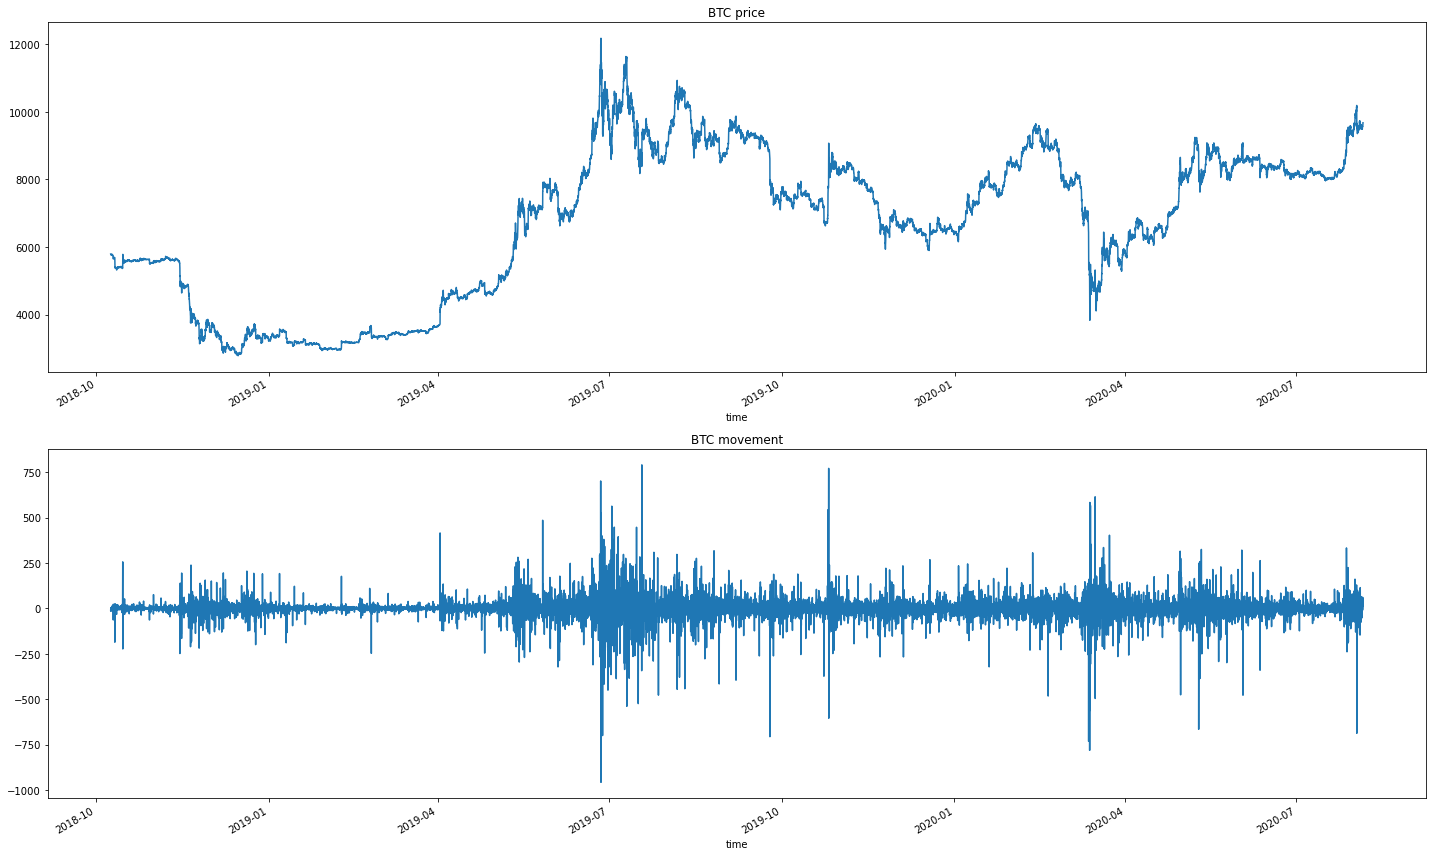

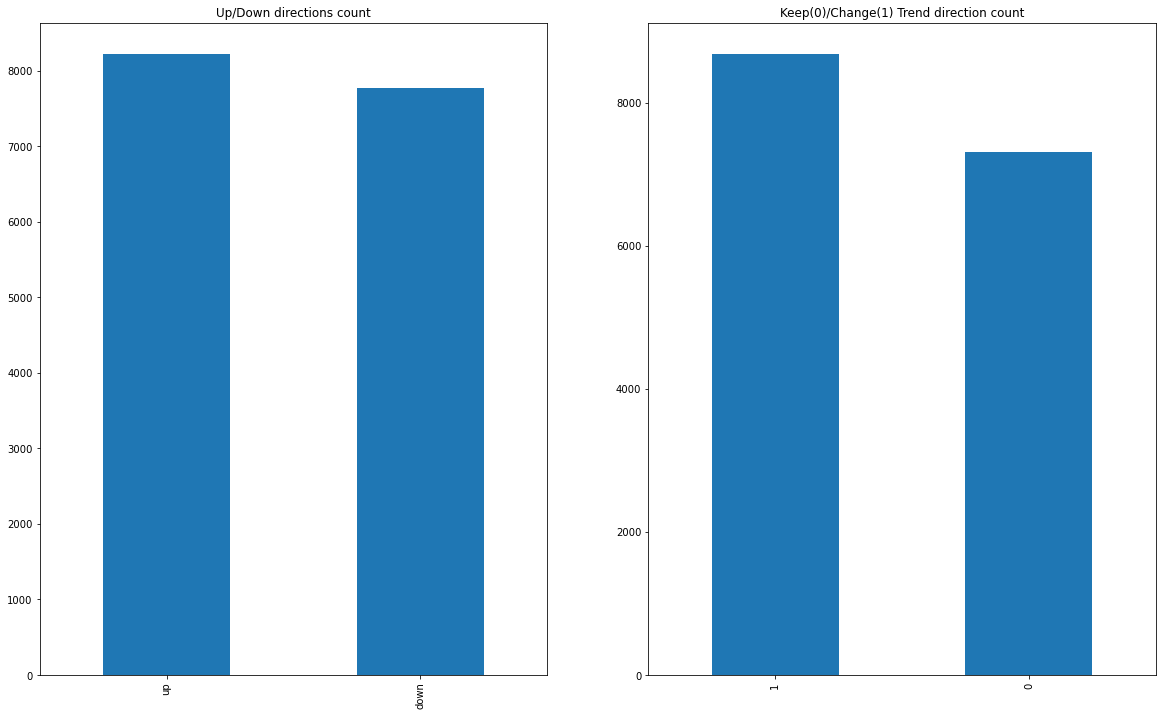

In [11]:
# PLOT OF THE BTC PRICE
fig, ax = plt.subplots(nrows=2)

_ = df['close'].plot(ax=ax[0], title='BTC price')
_ = df['close'].diff().plot(ax=ax[1], title='BTC movement')
_ = plt.tight_layout()

plt.show()

# 2 labels: up/down
price_mov = df['close'].diff().dropna()
price_mov_class = price_mov.apply(lambda x: 'up' if x>=0 else 'down')


fig, ax = plt.subplots(ncols=2)
_ = price_mov_class.value_counts().plot(kind='bar', title='Up/Down directions count', ax=ax[0])

# Same/Different trend as previous one
price_trend = (price_mov_class == price_mov_class.shift(1)).dropna()
price_trend = price_trend.map({True: 0, False: 1})

_ = price_trend.value_counts().plot(kind='bar', title='Keep(0)/Change(1) Trend direction count', ax=ax[1])

plt.show()


In [12]:
target = price_trend
class_weights = price_trend.value_counts().to_dict()
print(target)
print(class_weights)

time
2018-10-08 20:00:00    1
2018-10-08 21:00:00    1
2018-10-08 22:00:00    1
2018-10-08 23:00:00    1
2018-10-09 00:00:00    0
                      ..
2020-08-05 07:00:00    1
2020-08-05 08:00:00    0
2020-08-05 09:00:00    0
2020-08-05 10:00:00    0
2020-08-05 11:00:00    0
Name: close, Length: 15995, dtype: int64
{1: 8684, 0: 7311}


## Features Selection, Splitting
Kbest with f_classif criteria

In [13]:
# Align the features & Target indexes
feats_df['target'] = target
feats_df.dropna(inplace=True)
target = feats_df['target']
feats_df.drop(columns=['target'], inplace=True)

# Keep the 400 most relevant features
n_best = 400
kbest_selector = SelectKBest(f_classif, n_best)

# Fit on data
kbest_values = kbest_selector.fit_transform(feats_df, target)
kbest_df = pd.DataFrame(kbest_values,
                        index=feats_df.index,
                        columns=feats_df.loc[:, kbest_selector.get_support().tolist()].columns)

kbest_df.info()

c:\users\damien\pycharmprojects\btc_repo\testvenv2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass k=400 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15970 entries, 2018-10-09 21:00:00 to 2020-08-05 11:00:00
Columns: 400 entries, volumefrom to volumeto_mov24H.MMax12H.diff.Squared
dtypes: float64(400)
memory usage: 48.9 MB


In [14]:
# Add the 3rd dimension for the lags
look_back = 6

lagged = []
labels = []

# Add Lagged Features (from last to newest)
for l in range(look_back, 0, -1):
    print('- compute lag {}'.format(l))
    lagged.append(kbest_df.shift(l))
    labels += ['{}(t{})'.format(col, l) for col in kbest_df.columns]

# Add actual features dataframe (no lag)
lagged.append(kbest_df)
labels += kbest_df.columns.tolist()

# Put together into DF
third_df = pd.concat(lagged, axis=1)
third_df.columns = labels


# Align the features & Target indexes
third_df['target'] = target
third_df.dropna(inplace=True)
target = third_df['target']
third_df.drop(columns=['target'], inplace=True)


third_df.info()

- compute lag 6
- compute lag 5
- compute lag 4
- compute lag 3
- compute lag 2
- compute lag 1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15964 entries, 2018-10-10 03:00:00 to 2020-08-05 11:00:00
Columns: 2800 entries, volumefrom(t6) to volumeto_mov24H.MMax12H.diff.Squared
dtypes: float64(2800)
memory usage: 341.1 MB


In [15]:
# Split the data - validation on 1 week
batch_size = 32
n_test = 20 * batch_size
n_val = 5 * batch_size

# Number of obs to keep in train set to have a round number of batches
n_train = int((len(third_df) -n_test-n_val) / batch_size) * batch_size
print(len(third_df)-n_test-n_val)
print(int((len(third_df) -n_test-n_val) / batch_size))

print('Train: {}, Test:{}, Validation:{}'.format(n_train, n_test, n_val))

# Features splitting & Scaling
X_all = third_df.values
X_train = X_all[-n_train-n_test-n_val:-n_test-n_val, :]
X_test = X_all[-n_test-n_val:-n_val, :]
X_val = X_all[-n_val:, :]

print('- Features arrays shapes: {} {} {} {}'.format(X_all.shape, X_train.shape, X_test.shape, X_val.shape))

# Scale the values between [-1,1]
X_scaler = MinMaxScaler((-1,1))

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
X_val = X_scaler.transform(X_val)

# Reshape
X_train = X_train.reshape(n_train, look_back+1, n_best)
X_test = X_test.reshape(n_test, look_back+1, n_best)
X_val = X_val.reshape(n_val, look_back+1, n_best)

print('- Features arrays shapes: {} {} {}'.format(X_train.shape, X_test.shape, X_val.shape))

# Targets
y_all = target.values
y_train = y_all[-n_train-n_test-n_val:-n_test-n_val]
y_test = y_all[-n_test-n_val:-n_val]
y_val = y_all[-n_val:]

print('- Target arrays shapes: {} {} {}'.format(y_train.shape, y_test.shape, y_val.shape))


15164
473
Train: 15136, Test:640, Validation:160
- Features arrays shapes: (15964, 2800) (15136, 2800) (640, 2800) (160, 2800)
- Features arrays shapes: (15136, 7, 400) (640, 7, 400) (160, 7, 400)
- Target arrays shapes: (15136,) (640,) (160,)


## Model: LSTM 

In [37]:
# Parameters
activation = 'tanh'
dropout_rate = 0
lr = 1e-5
n_epochs = 800

In [38]:
# Network Architecture
lstm = Sequential()


lstm.add(LSTM(300, activation=activation, stateful=True,
              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
              return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))

lstm.add(SpatialDropout1D(0.1))

#lstm.add(LSTM(200, activation=activation, stateful=True,
#              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
#              return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))

#lstm.add(LSTM(100, activation=activation, stateful=True,
#              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
#              return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))

lstm.add(LSTM(20, activation=activation, stateful=True,
              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
              return_sequences=False, dropout=dropout_rate, recurrent_dropout=dropout_rate))


# Output layer
lstm.add(Dense(1, activation='sigmoid'))


print(lstm.summary())




Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (32, 7, 300)              841200    
_________________________________________________________________
lstm_14 (LSTM)               (32, 20)                  25680     
_________________________________________________________________
dense_6 (Dense)              (32, 1)                   21        
Total params: 866,901
Trainable params: 866,901
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Compiling Optimizer
rmsprop = RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
lstm.compile(loss='binary_crossentropy', optimizer=rmsprop, 
             metrics=['accuracy'
                      #AUC(name='AUC', multi_label=False, label_weights=class_weights))
                     ])


# Callbacks
callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=10, min_lr=1e-9)]

# Loss arrays
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
counter = 1

for n in range(n_epochs):
    print('** epoch {}/{} **'.format(counter, n_epochs))

    history = lstm.fit(x=X_train, y=y_train, epochs=1, validation_data=(X_test, y_test),
                       batch_size=batch_size, shuffle=False, callbacks=callbacks,
                      class_weight=class_weights,
                      use_multiprocessing=True)

    # Append the list to follow the evolution of loss on train and test sets
    train_loss_list.append(history.history['loss'][0])
    train_acc_list.append(history.history['acc'][0])

    test_loss_list.append(history.history['val_loss'][0])
    test_acc_list.append(history.history['val_acc'][0])


    # Reset the cell states (required for stateful)
    lstm.reset_states()

    counter += 1


** epoch 1/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 93s 6ms/step - loss: 5503.1092 - acc: 0.5422 - val_loss: 0.6900 - val_acc: 0.5563
** epoch 2/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5482.0190 - acc: 0.5421 - val_loss: 0.6898 - val_acc: 0.5563
** epoch 3/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5483.8240 - acc: 0.5422 - val_loss: 0.6898 - val_acc: 0.5563
** epoch 4/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5477.6605 - acc: 0.5429 - val_loss: 0.6892 - val_acc: 0.5563
** epoch 5/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5472.8044 - acc: 0.5426 - val_loss: 

15136/15136 [==============================] - 85s 6ms/step - loss: 5419.1470 - acc: 0.5556 - val_loss: 0.6809 - val_acc: 0.5625
** epoch 81/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5414.1664 - acc: 0.5565 - val_loss: 0.6807 - val_acc: 0.5625
** epoch 82/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5414.2031 - acc: 0.5579 - val_loss: 0.6806 - val_acc: 0.5656
** epoch 83/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5414.1434 - acc: 0.5566 - val_loss: 0.6805 - val_acc: 0.5656
** epoch 84/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5413.1683 - acc: 0.5565 - val_loss: 0.6804 - val_acc: 0.5672
** epoch 85/800 **
Train on 15136 samples, vali

15136/15136 [==============================] - 85s 6ms/step - loss: 5395.2505 - acc: 0.5614 - val_loss: 0.6776 - val_acc: 0.5719
** epoch 121/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5393.2298 - acc: 0.5625 - val_loss: 0.6774 - val_acc: 0.5719
** epoch 122/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5392.9303 - acc: 0.5620 - val_loss: 0.6774 - val_acc: 0.5719
** epoch 123/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5392.3749 - acc: 0.5628 - val_loss: 0.6774 - val_acc: 0.5703
** epoch 124/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5392.1805 - acc: 0.5645 - val_loss: 0.6772 - val_acc: 0.5703
** epoch 125/800 **
Train on 15136 samples,

** epoch 160/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5370.9121 - acc: 0.5665 - val_loss: 0.6750 - val_acc: 0.5719
** epoch 161/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5376.5179 - acc: 0.5663 - val_loss: 0.6750 - val_acc: 0.5719
** epoch 162/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5372.9016 - acc: 0.5674 - val_loss: 0.6749 - val_acc: 0.5750
** epoch 163/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5375.4237 - acc: 0.5679 - val_loss: 0.6747 - val_acc: 0.5750
** epoch 164/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5373.0331 - acc: 0.5676 - 

** epoch 239/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 78s 5ms/step - loss: 5335.5125 - acc: 0.5764 - val_loss: 0.6698 - val_acc: 0.5828
** epoch 240/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 82s 5ms/step - loss: 5339.7726 - acc: 0.5778 - val_loss: 0.6701 - val_acc: 0.5828
** epoch 241/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5337.7255 - acc: 0.5763 - val_loss: 0.6701 - val_acc: 0.5828
** epoch 242/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5327.4464 - acc: 0.5777 - val_loss: 0.6697 - val_acc: 0.5828
** epoch 243/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5336.7426 - acc: 0.5766 - 

15136/15136 [==============================] - 85s 6ms/step - loss: 5305.1370 - acc: 0.5842 - val_loss: 0.6659 - val_acc: 0.5891
** epoch 318/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5295.5040 - acc: 0.5852 - val_loss: 0.6657 - val_acc: 0.59064.0919
** epoch 319/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5290.8651 - acc: 0.5833 - val_loss: 0.6652 - val_acc: 0.5922
** epoch 320/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5289.2625 - acc: 0.5846 - val_loss: 0.6656 - val_acc: 0.5906
** epoch 321/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5295.8873 - acc: 0.5842 - val_loss: 0.6655 - val_acc: 0.5906
** epoch 322/800 **
Train on 15136 sa

15136/15136 [==============================] - 84s 6ms/step - loss: 5254.4504 - acc: 0.5887 - val_loss: 0.6620 - val_acc: 0.6047
** epoch 396/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5260.6821 - acc: 0.5917 - val_loss: 0.6622 - val_acc: 0.6062
** epoch 397/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5265.1100 - acc: 0.5907 - val_loss: 0.6625 - val_acc: 0.6047
** epoch 398/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5258.3268 - acc: 0.5901 - val_loss: 0.6631 - val_acc: 0.6016
** epoch 399/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5254.0001 - acc: 0.5910 - val_loss: 0.6627 - val_acc: 0.6031
** epoch 400/800 **
Train on 15136 samples,

15136/15136 [==============================] - 84s 6ms/step - loss: 5211.0874 - acc: 0.5953 - val_loss: 0.6602 - val_acc: 0.6078
** epoch 474/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5226.8167 - acc: 0.5964 - val_loss: 0.6603 - val_acc: 0.6078
** epoch 475/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5216.7671 - acc: 0.5953 - val_loss: 0.6603 - val_acc: 0.6078
** epoch 476/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5226.4852 - acc: 0.5969 - val_loss: 0.6605 - val_acc: 0.6078
** epoch 477/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5222.0877 - acc: 0.5962 - val_loss: 0.6602 - val_acc: 0.6078
** epoch 478/800 **
Train on 15136 samples,

15136/15136 [==============================] - 85s 6ms/step - loss: 5189.3838 - acc: 0.6003 - val_loss: 0.6575 - val_acc: 0.6078
** epoch 552/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5186.7064 - acc: 0.6025 - val_loss: 0.6582 - val_acc: 0.6062
** epoch 553/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 81s 5ms/step - loss: 5181.1064 - acc: 0.6038 - val_loss: 0.6578 - val_acc: 0.6094
** epoch 554/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5186.0662 - acc: 0.6024 - val_loss: 0.6580 - val_acc: 0.6094
** epoch 555/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5186.6847 - acc: 0.6026 - val_loss: 0.6587 - val_acc: 0.6062
** epoch 556/800 **
Train on 15136 samples,

15136/15136 [==============================] - 84s 6ms/step - loss: 5147.9410 - acc: 0.6066 - val_loss: 0.6552 - val_acc: 0.6125
** epoch 630/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5150.2555 - acc: 0.6058 - val_loss: 0.6553 - val_acc: 0.6109
** epoch 631/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5152.7409 - acc: 0.6052 - val_loss: 0.6553 - val_acc: 0.6125
** epoch 632/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5151.5290 - acc: 0.6016 - val_loss: 0.6551 - val_acc: 0.6078
** epoch 633/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5162.0155 - acc: 0.6057 - val_loss: 0.6552 - val_acc: 0.6109
** epoch 634/800 **
Train on 15136 samples,

15136/15136 [==============================] - 84s 6ms/step - loss: 5127.0818 - acc: 0.6070 - val_loss: 0.6521 - val_acc: 0.6172
** epoch 708/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5128.3583 - acc: 0.6082 - val_loss: 0.6525 - val_acc: 0.6062
** epoch 709/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5101.7627 - acc: 0.6082 - val_loss: 0.6522 - val_acc: 0.6094
** epoch 710/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5118.6081 - acc: 0.6091 - val_loss: 0.6520 - val_acc: 0.6094
** epoch 711/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5112.5771 - acc: 0.6137 - val_loss: 0.6531 - val_acc: 0.6141
** epoch 712/800 **
Train on 15136 samples,

15136/15136 [==============================] - 85s 6ms/step - loss: 5095.9481 - acc: 0.6122 - val_loss: 0.6511 - val_acc: 0.6109
** epoch 786/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5083.8550 - acc: 0.6138 - val_loss: 0.6501 - val_acc: 0.6156
** epoch 787/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5099.1904 - acc: 0.6130 - val_loss: 0.6511 - val_acc: 0.6156
** epoch 788/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5071.9731 - acc: 0.6147 - val_loss: 0.6515 - val_acc: 0.6109
** epoch 789/800 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5102.6420 - acc: 0.6092 - val_loss: 0.6517 - val_acc: 0.6109
** epoch 790/800 **
Train on 15136 samples,

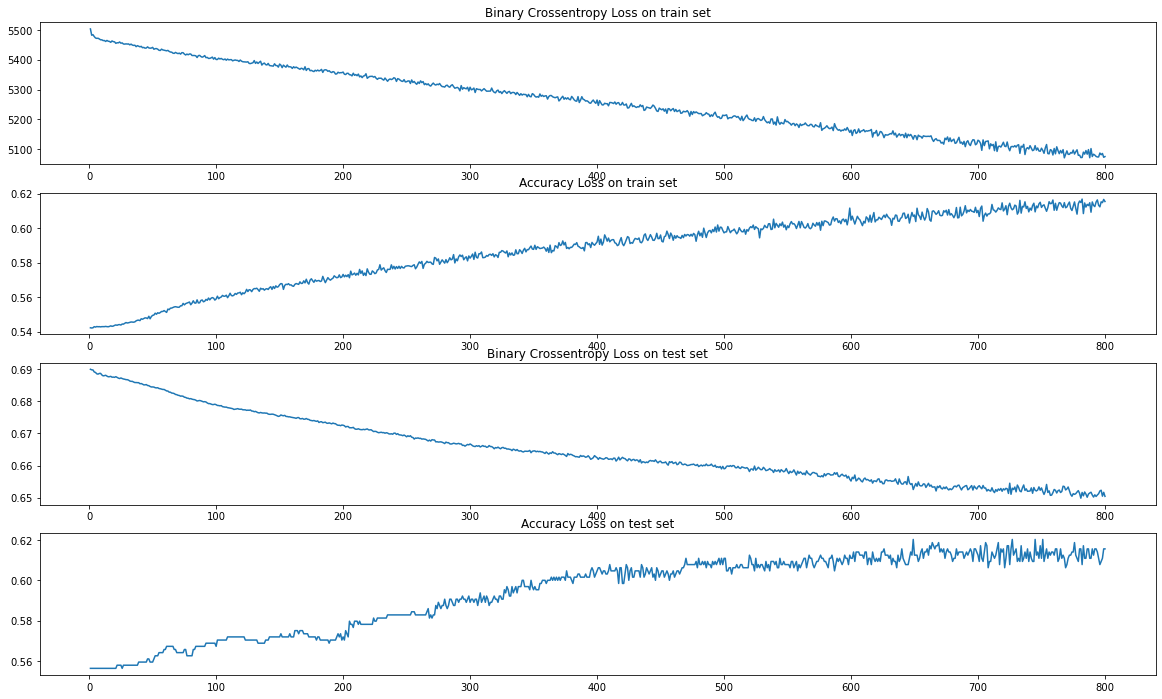

In [40]:
# Plot the errors
fig, ax = plt.subplots(nrows=4)
_ = ax[0].plot(range(1, counter), train_loss_list)
_ = ax[0].set_title('Binary Crossentropy Loss on train set')

_ = ax[1].plot(range(1, counter), train_acc_list) 
_ = ax[1].set_title('Accuracy Loss on train set')

_ = ax[2].plot(range(1, counter), test_loss_list)
_ = ax[2].set_title('Binary Crossentropy Loss on test set')

_ = ax[3].plot(range(1, counter), test_acc_list)
_ = ax[3].set_title('Accuracy Loss on test set')

plt.show()


In [42]:
path = "Trained/BTC_LSTM_{}ep.h5".format(n_epochs) 
lstm.save(path)  

In [ ]:
# Resume training
n_epochs_resume = 1600

for n in range(n_epochs_resume):
    print('epoch {}/{} **'.format(counter, n_epochs_resume))

    history = lstm.fit(x=X_train, y=y_train, epochs=1, validation_data=(X_test, y_test),
                       batch_size=batch_size, shuffle=False, callbacks=callbacks,
                      class_weight=class_weights,
                      use_multiprocessing=True)

     # Append the list to follow the evolution of loss on train and test sets
    train_loss_list.append(history.history['loss'][0])
    train_acc_list.append(history.history['acc'][0])

    test_loss_list.append(history.history['val_loss'][0])
    test_acc_list.append(history.history['val_acc'][0])


    # Reset the cell states (required for stateful)
    lstm.reset_states()

    counter += 1

epoch 801/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5088.0004 - acc: 0.6124 - val_loss: 0.6516 - val_acc: 0.6094
epoch 802/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5082.1247 - acc: 0.6109 - val_loss: 0.6510 - val_acc: 0.6156
epoch 803/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5073.4873 - acc: 0.6171 - val_loss: 0.6518 - val_acc: 0.6094
epoch 804/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5073.3905 - acc: 0.6154 - val_loss: 0.6507 - val_acc: 0.6188
epoch 805/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5075.6087 - acc: 0.6161 - val_loss: 

15136/15136 [==============================] - 85s 6ms/step - loss: 5037.8910 - acc: 0.6187 - val_loss: 0.6508 - val_acc: 0.6109
epoch 881/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5042.5145 - acc: 0.6206 - val_loss: 0.6513 - val_acc: 0.6172
epoch 882/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5046.4997 - acc: 0.6185 - val_loss: 0.6507 - val_acc: 0.6141
epoch 883/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5035.4425 - acc: 0.6182 - val_loss: 0.6514 - val_acc: 0.6156
epoch 884/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5042.3809 - acc: 0.6202 - val_loss: 0.6513 - val_acc: 0.6125
epoch 885/1600 **
Train on 15136 samples, validate 

15136/15136 [==============================] - 85s 6ms/step - loss: 5036.5155 - acc: 0.6177 - val_loss: 0.6520 - val_acc: 0.6062
epoch 921/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5020.0847 - acc: 0.6228 - val_loss: 0.6516 - val_acc: 0.6125
epoch 922/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5018.3200 - acc: 0.6217 - val_loss: 0.6534 - val_acc: 0.6047
epoch 923/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5019.7818 - acc: 0.6196 - val_loss: 0.6538 - val_acc: 0.6078
epoch 924/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5026.9223 - acc: 0.6218 - val_loss: 0.6509 - val_acc: 0.6094
epoch 925/1600 **
Train on 15136 samples, validate 

15136/15136 [==============================] - 84s 6ms/step - loss: 5019.3450 - acc: 0.6200 - val_loss: 0.6514 - val_acc: 0.6094
epoch 961/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5021.7897 - acc: 0.6201 - val_loss: 0.6513 - val_acc: 0.6062
epoch 962/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5022.1033 - acc: 0.6202 - val_loss: 0.6511 - val_acc: 0.6109
epoch 963/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 5010.3989 - acc: 0.6214 - val_loss: 0.6513 - val_acc: 0.6094
epoch 964/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 5002.1175 - acc: 0.6255 - val_loss: 0.6511 - val_acc: 0.6094
epoch 965/1600 **
Train on 15136 samples, validate 

15136/15136 [==============================] - 86s 6ms/step - loss: 5005.0792 - acc: 0.6224 - val_loss: 0.6521 - val_acc: 0.6109
epoch 1001/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5002.0886 - acc: 0.6236 - val_loss: 0.6523 - val_acc: 0.6109
epoch 1002/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4995.6174 - acc: 0.6232 - val_loss: 0.6534 - val_acc: 0.6062
epoch 1003/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 5001.7220 - acc: 0.6247 - val_loss: 0.6535 - val_acc: 0.6047
epoch 1004/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4996.1156 - acc: 0.6243 - val_loss: 0.6529 - val_acc: 0.6109
epoch 1005/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 85s 6ms/step - loss: 4981.0687 - acc: 0.6215 - val_loss: 0.6518 - val_acc: 0.6094
epoch 1041/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4996.4443 - acc: 0.6250 - val_loss: 0.6533 - val_acc: 0.6047
epoch 1042/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4973.8951 - acc: 0.6242 - val_loss: 0.6522 - val_acc: 0.6078
epoch 1043/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 4973.6888 - acc: 0.6251 - val_loss: 0.6518 - val_acc: 0.6094
epoch 1044/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 83s 6ms/step - loss: 4977.8097 - acc: 0.6277 - val_loss: 0.6508 - val_acc: 0.6125
epoch 1045/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 83s 5ms/step - loss: 4946.7823 - acc: 0.6305 - val_loss: 0.6515 - val_acc: 0.6062
epoch 1120/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 86s 6ms/step - loss: 4942.7594 - acc: 0.6315 - val_loss: 0.6513 - val_acc: 0.6141
epoch 1121/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4947.8201 - acc: 0.6300 - val_loss: 0.6508 - val_acc: 0.6219
epoch 1122/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4968.9893 - acc: 0.6285 - val_loss: 0.6521 - val_acc: 0.6062
epoch 1123/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4957.1906 - acc: 0.6270 - val_loss: 0.6520 - val_acc: 0.6109
epoch 1124/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 85s 6ms/step - loss: 4933.1339 - acc: 0.6317 - val_loss: 0.6509 - val_acc: 0.6156
epoch 1160/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4920.1672 - acc: 0.6321 - val_loss: 0.6518 - val_acc: 0.6125
epoch 1161/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4926.5914 - acc: 0.6310 - val_loss: 0.6518 - val_acc: 0.6141
epoch 1162/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 83s 6ms/step - loss: 4943.8053 - acc: 0.6307 - val_loss: 0.6516 - val_acc: 0.6125
epoch 1163/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4936.0690 - acc: 0.6287 - val_loss: 0.6530 - val_acc: 0.6156
epoch 1164/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 85s 6ms/step - loss: 4910.6781 - acc: 0.6323 - val_loss: 0.6533 - val_acc: 0.6047
epoch 1200/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4918.0572 - acc: 0.6346 - val_loss: 0.6520 - val_acc: 0.6062
epoch 1201/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4905.6943 - acc: 0.6331 - val_loss: 0.6522 - val_acc: 0.6156
epoch 1202/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4909.3818 - acc: 0.6386 - val_loss: 0.6525 - val_acc: 0.6094
epoch 1203/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4912.7353 - acc: 0.6337 - val_loss: 0.6537 - val_acc: 0.6047
epoch 1204/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 85s 6ms/step - loss: 4900.8665 - acc: 0.6337 - val_loss: 0.6542 - val_acc: 0.6062
epoch 1240/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4881.9858 - acc: 0.6371 - val_loss: 0.6523 - val_acc: 0.6141
epoch 1241/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4869.1426 - acc: 0.6378 - val_loss: 0.6533 - val_acc: 0.6109
epoch 1242/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4888.8423 - acc: 0.6376 - val_loss: 0.6527 - val_acc: 0.6156
epoch 1243/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4889.2355 - acc: 0.6363 - val_loss: 0.6544 - val_acc: 0.6109
epoch 1244/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 84s 6ms/step - loss: 4884.4741 - acc: 0.6378 - val_loss: 0.6539 - val_acc: 0.6125
epoch 1280/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4874.8013 - acc: 0.6389 - val_loss: 0.6540 - val_acc: 0.6109
epoch 1281/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4870.9682 - acc: 0.6389 - val_loss: 0.6533 - val_acc: 0.6125
epoch 1282/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4868.8091 - acc: 0.6391 - val_loss: 0.6533 - val_acc: 0.6188
epoch 1283/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4885.3778 - acc: 0.6348 - val_loss: 0.6524 - val_acc: 0.6188
epoch 1284/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 84s 6ms/step - loss: 4858.2758 - acc: 0.6404 - val_loss: 0.6550 - val_acc: 0.6000
epoch 1320/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4847.3365 - acc: 0.6391 - val_loss: 0.6546 - val_acc: 0.6125
epoch 1321/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4863.4566 - acc: 0.6377 - val_loss: 0.6538 - val_acc: 0.6156
epoch 1322/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4853.3205 - acc: 0.6391 - val_loss: 0.6539 - val_acc: 0.6156
epoch 1323/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4858.9587 - acc: 0.6409 - val_loss: 0.6550 - val_acc: 0.6078
epoch 1324/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 84s 6ms/step - loss: 4823.8594 - acc: 0.6399 - val_loss: 0.6522 - val_acc: 0.6141
epoch 1360/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 83s 5ms/step - loss: 4849.7962 - acc: 0.6370 - val_loss: 0.6551 - val_acc: 0.6016
epoch 1361/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4844.2936 - acc: 0.6411 - val_loss: 0.6544 - val_acc: 0.6094
epoch 1362/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4833.9227 - acc: 0.6418 - val_loss: 0.6544 - val_acc: 0.6078
epoch 1363/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4817.7617 - acc: 0.6446 - val_loss: 0.6542 - val_acc: 0.6125
epoch 1364/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 85s 6ms/step - loss: 4790.7387 - acc: 0.6481 - val_loss: 0.6573 - val_acc: 0.6047
epoch 1439/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4787.6251 - acc: 0.6475 - val_loss: 0.6558 - val_acc: 0.6031
epoch 1440/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4799.7543 - acc: 0.6439 - val_loss: 0.6555 - val_acc: 0.6047
epoch 1441/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 83s 5ms/step - loss: 4792.0608 - acc: 0.6459 - val_loss: 0.6566 - val_acc: 0.6047
epoch 1442/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4794.8679 - acc: 0.6454 - val_loss: 0.6540 - val_acc: 0.6078
epoch 1443/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 84s 6ms/step - loss: 4789.0630 - acc: 0.6498 - val_loss: 0.6536 - val_acc: 0.6172
epoch 1479/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4784.7369 - acc: 0.6455 - val_loss: 0.6562 - val_acc: 0.6031
epoch 1480/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4787.5732 - acc: 0.6489 - val_loss: 0.6570 - val_acc: 0.6094
epoch 1481/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4779.5546 - acc: 0.6434 - val_loss: 0.6568 - val_acc: 0.6109
epoch 1482/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4812.1779 - acc: 0.6469 - val_loss: 0.6549 - val_acc: 0.6016
epoch 1483/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 87s 6ms/step - loss: 4732.3154 - acc: 0.6528 - val_loss: 0.6535 - val_acc: 0.6297
epoch 1557/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4720.5663 - acc: 0.6550 - val_loss: 0.6531 - val_acc: 0.6188
epoch 1558/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 83s 6ms/step - loss: 4725.4453 - acc: 0.6517 - val_loss: 0.6552 - val_acc: 0.6078
epoch 1559/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4723.4903 - acc: 0.6512 - val_loss: 0.6555 - val_acc: 0.6094
epoch 1560/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4759.8401 - acc: 0.6489 - val_loss: 0.6561 - val_acc: 0.5984
epoch 1561/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 84s 6ms/step - loss: 4719.2126 - acc: 0.6506 - val_loss: 0.6560 - val_acc: 0.6078
epoch 1597/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4705.8938 - acc: 0.6584 - val_loss: 0.6559 - val_acc: 0.6047
epoch 1598/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4716.3672 - acc: 0.6534 - val_loss: 0.6555 - val_acc: 0.6078
epoch 1599/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4744.2922 - acc: 0.6520 - val_loss: 0.6551 - val_acc: 0.6031
epoch 1600/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 85s 6ms/step - loss: 4697.7624 - acc: 0.6581 - val_loss: 0.6564 - val_acc: 0.6109 -
epoch 1601/1600 **
Train on 15136 samples, va

15136/15136 [==============================] - 84s 6ms/step - loss: 4682.7503 - acc: 0.6583 - val_loss: 0.6570 - val_acc: 0.6125
epoch 1637/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4696.8021 - acc: 0.6574 - val_loss: 0.6604 - val_acc: 0.6094
epoch 1638/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4680.9806 - acc: 0.6605 - val_loss: 0.6567 - val_acc: 0.6234
epoch 1639/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 84s 6ms/step - loss: 4682.5867 - acc: 0.6586 - val_loss: 0.6571 - val_acc: 0.6203
epoch 1640/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 83s 6ms/step - loss: 4678.0880 - acc: 0.6587 - val_loss: 0.6568 - val_acc: 0.6094
epoch 1641/1600 **
Train on 15136 samples, vali

15136/15136 [==============================] - 121s 8ms/step - loss: 4680.7941 - acc: 0.6592 - val_loss: 0.6586 - val_acc: 0.6094
epoch 1677/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 138s 9ms/step - loss: 4638.3742 - acc: 0.6644 - val_loss: 0.6588 - val_acc: 0.6109
epoch 1678/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 110s 7ms/step - loss: 4682.9603 - acc: 0.6571 - val_loss: 0.6584 - val_acc: 0.6078
epoch 1679/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 121s 8ms/step - loss: 4645.2026 - acc: 0.6634 - val_loss: 0.6587 - val_acc: 0.6203
epoch 1680/1600 **
Train on 15136 samples, validate on 640 samples
Epoch 1/1
15136/15136 [==============================] - 104s 7ms/step - loss: 4685.8708 - acc: 0.6580 - val_loss: 0.6605 - val_acc: 0.6031
epoch 1681/1600 **
Train on 15136 samples,

In [ ]:
# Plot the errors
fig, ax = plt.subplots(nrows=4)
_ = ax[0].plot(range(1, counter), train_loss_list)
_ = ax[0].set_title('Binary Crossentropy Loss on train set')

_ = ax[1].plot(range(1, counter), train_acc_list)
_ = ax[1].set_title('Accuracy Loss on train set')

_ = ax[2].plot(range(1, counter), test_loss_list)
_ = ax[2].set_title('Binary Crossentropy Loss on test set')

_ = ax[3].plot(range(1, counter), test_acc_list)
_ = ax[3].set_title('Accuracy Loss on test set')

plt.show()


In [ ]:
path = "Trained/BTC_LSTM_{}ep.h5".format(n_epochs + n_epochs_resume) 
lstm.save(path)

## Load and Retrain

In [ ]:
path = 'Trained/BTC_LSTM_400ep.h5"
lstm = keras.models.load_model(path)

OSError: ignored

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

In [ ]:
# Resume training
n_epochs_resume = 400

for n in range(n_epochs_resume):
    print('epoch {}/{} **'.format(counter, n_epochs_resume))

    history = lstm.fit(x=X_train, y=y_train, epochs=1, validation_data=(X_test, y_test),
                       batch_size=batch_size, shuffle=False, callbacks=callbacks,
                      class_weight=class_weights,
                      use_multiprocessing=True)

     # Append the list to follow the evolution of loss on train and test sets
    train_loss_list.append(history.history['loss'][0])
    train_acc_list.append(history.history['acc'][0])

    test_loss_list.append(history.history['val_loss'][0])
    test_acc_list.append(history.history['val_acc'][0])


    # Reset the cell states (required for stateful)
    lstm.reset_states()

    counter += 1

NameError: ignored

In [ ]:
# Plot the errors
fig, ax = plt.subplots(nrows=4)
_ = ax[0].plot(range(1, counter), train_loss_list)
_ = ax[0].set_title('Binary Crossentropy Loss on train set')

_ = ax[1].plot(range(1, counter), train_acc_list)
_ = ax[1].set_title('Accuracy Loss on train set')

_ = ax[2].plot(range(1, counter), test_loss_list)
_ = ax[2].set_title('Binary Crossentropy Loss on test set')

_ = ax[3].plot(range(1, counter), test_acc_list)
_ = ax[3].set_title('Accuracy Loss on test set')

plt.show()
